<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Copy_of_Lesson_7_2_GAN_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7: Resnets from scratch; U-net;  & GAN

https://course.fast.ai/videos/?lesson=7

https://github.com/hiromis/notes/blob/master/Lesson7.md



In the final lesson of Practical Deep Learning for Coders we'll study one of the most important techniques in modern architectures: the skip connection. This is most famously used in the resnet, which is the architecture we've used throughout this course for image classification, and appears in many cutting edge results. We'll also look at the U-net architecture, which uses a different type of skip connection to greatly improve segmentation results (and also for similar tasks where the output structure is similar to the input).

We'll then use the U-net architecture to train a super-resolution model. This is a model which can increase the resolution of a low-quality image. Our model won't only increase resolution—it will also remove jpeg artifacts, and remove unwanted text watermarks.

In order to make our model produce high quality results, we will need to create a custom loss function which incorporates feature loss (also known as perceptual loss), along with gram loss. These techniques can be used for many other types of image generation task, such as image colorization.

Finally, we'll learn about a recent loss function known as generative adversarial loss (used in generative adversarial networks, or GANs), which can improve the quality of generative models in some contexts, at the cost of speed.

The techniques we show in this lesson include some unpublished research that:

* Let us train GANs more quickly and reliably than standard approaches, by leveraging transfer learning
* Combines architectural innovations and loss function approaches that haven't been used in this way before.

The results are stunning, and train in just a couple of hours (compared to previous approaches that take a couple of days).

# Notes


## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install folium==0.2.1

!pip install --upgrade pandas

!pip install --upgrade numpy

!pip install isoweek

#!pip install --upgrade fastai

# install "crappify"
! wget https://raw.githubusercontent.com/fastai/course-v3/master/nbs/dl1/crappify.py

!curl -s https://course.fast.ai/setup/colab | bash

## Constants & global flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [15]:
import fastai
from fastai import *
from fastai.basics import *
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from fastai.metrics import error_rate
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Requires script download, see install section 
from crappify import *


print("FastAI Version: " + str(fastai.__version__))

FastAI Version: 1.0.51


In [2]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## CUDA GPU *acceleration*

In [0]:
def check_cuda():
  torch.cuda.current_device()
  print("Cuda available: " + str(torch.cuda.is_available()))
  print("Cuda enabled:" + str(torch.backends.cudnn.enabled))
  #https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
  # setting device on GPU if available, else CPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  print()
  #Additional Info when using cuda
  if device.type == 'cuda':
    check_cuda_mem()


In [0]:
def check_cuda_mem():
      print("GPU used: " + torch.cuda.get_device_name(0))
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
  

In [0]:
def clear_cuda_cache(learn):
  # Clear Cuda cache, if running OOM
    learn.destroy()
    torch.cuda.empty_cache()
    check_cuda_mem()

In [7]:
check_cuda()

Cuda available: True
Cuda enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Crappified data¶

Prepare the input data by crappifying images.

In [0]:
# get data 
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [18]:
# Uncomment the first time you run this notebook.

# il = ImageList.from_folder(path_hr)
# parallel(crappifier(path_lr, path_hr), il.items)

In [0]:
# For gradual resizing we can change the commented line here.

bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator¶
Now let's pretrain the generator.

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)
data_gen.show_batch(4)

In [0]:
# set weight decay rate
wd = 1e-3


In [0]:
# set target variable range
y_range = (-3.,3.)


In [0]:
loss_gen = MSELossFlat()


In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()


In [53]:
learn_gen.fit_one_cycle(3, pct_start=0.8)


epoch,train_loss,valid_loss,time
0,0.074785,0.064206,03:00
1,0.055689,0.055380,03:00
2,0.050329,0.047713,03:00


In [54]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.049519,0.048842,03:09
1,0.047768,0.045922,03:10
2,0.046812,0.044514,03:09


In [0]:
learn_gen.save('gen-pre2')


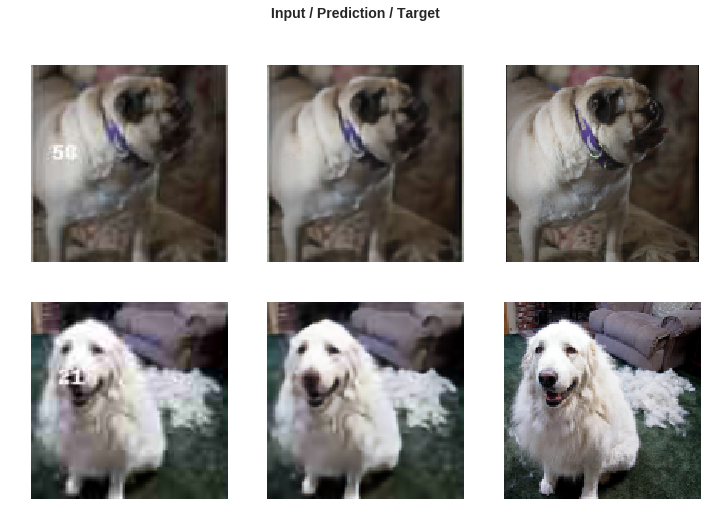

In [55]:
learn_gen.show_results(rows=2)


# Save generated images

In [0]:
learn_gen.load('gen-pre2');


In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
# shutil.rmtree(path_gen)

In [0]:
path_gen.mkdir(exist_ok=True)


In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)


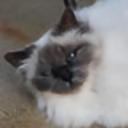

In [63]:
PIL.Image.open(path_gen.ls()[0])


# Train critic

In [64]:
# Free memory 
learn_gen=None
gc.collect()

20

Pretrain the critic on crappy vs not crappy.



In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)


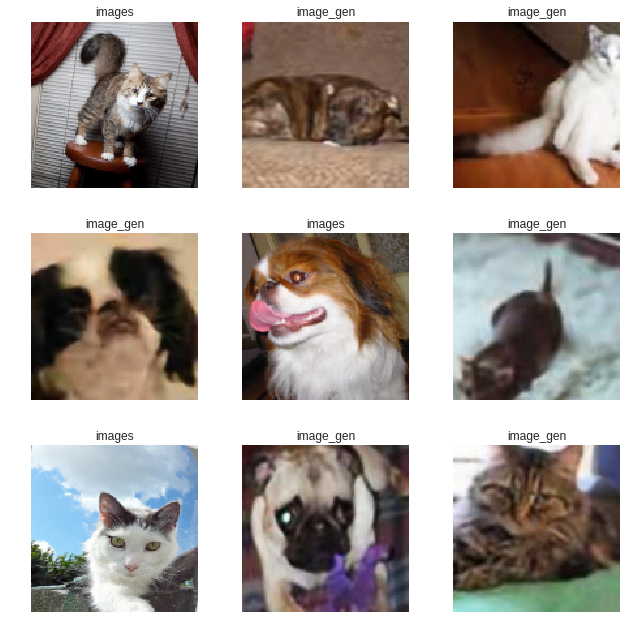

In [67]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)


In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())


In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)


In [0]:
learn_critic.fit_one_cycle(6, 1e-3)


epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.689579,0.688135,0.588946,06:54


In [0]:
learn_critic.save('critic-pre2')


#GAN 

Now we'll combine those pretrained model in a GAN.



In [0]:
learn_crit=None
learn_gen=None
gc.collect()

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)


In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')


In [0]:
learn_gen = create_gen_learner().load('gen-pre2')


To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by learn_crit.loss_func. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)


In [0]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
# set epochs & learn rate
ep = 3 #40
lr = 1e-4


In [0]:
learn.fit(ep,lr)


In [0]:
learn.save('gan-1c')


In [0]:
learn.data=get_data(16,192)


In [0]:
learn.fit(10,lr/2)


In [0]:
learn.show_results(rows=16)
